IMPORTING LIBRARIES

In [147]:
#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#speech processing libraries
import librosa
import librosa.display
import soundfile as sf
from IPython.display import Audio
import os
#import resampy
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

#ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix,classification_report
from sklearn.svm import SVC #supervised learning for multi-class classification

#DL libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import (
    classification_report, confusion_matrix, accuracy_score
)

# Audio Processing
#import pyaudio
import joblib
import pickle

# Web Framework
import streamlit as st


DATA VISUALISATION

In [148]:
Dataset = "/Users/nikhilraj/Desktop/SER-ML/AudioDatasets" 
file_emotion = []
file_path = []

# Traversing through speech and song directories
for root, directories, files in os.walk(Dataset):
    for file_name in files:
        if file_name.endswith('.wav'):
            parts = file_name.split('-')
            if len(parts) >= 3:
                emotion_code = parts[2]
                file_emotion.append(emotion_code)
                file_path.append(os.path.join(root, file_name))
            else:
                print(f"Unexpected filename format: {file_name}")

emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
path_df = pd.DataFrame(file_path, columns=['Path'])
df = pd.concat([emotion_df, path_df], axis=1)

df.Emotions.replace({
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fear', '07': 'disgust', '08': 'surprise'
}, inplace=True)

# Previewing the final dataframe
df.head()

,Emotions,Path
0,happy,/Users/nikhilraj/Desktop/SER-ML/AudioDatasets/...
1,happy,/Users/nikhilraj/Desktop/SER-ML/AudioDatasets/...
2,calm,/Users/nikhilraj/Desktop/SER-ML/AudioDatasets/...
3,calm,/Users/nikhilraj/Desktop/SER-ML/AudioDatasets/...
4,neutral,/Users/nikhilraj/Desktop/SER-ML/AudioDatasets/...


In [149]:
#to csv file
print(df.shape)
df.to_csv("df.csv",index=False)

(2452, 2)


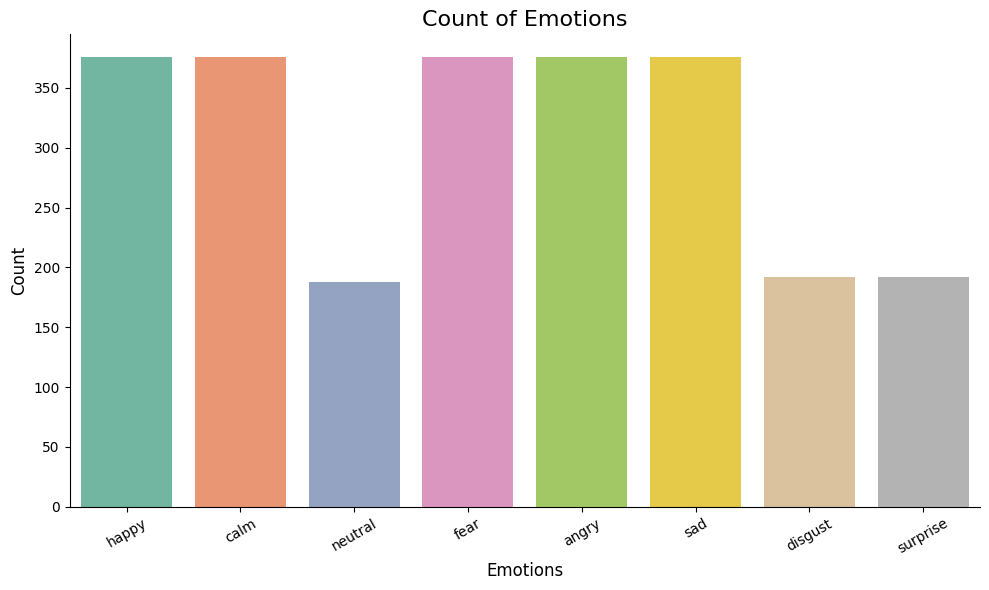

Emotions
happy       376
calm        376
fear        376
angry       376
sad         376
disgust     192
surprise    192
neutral     188
Name: count, dtype: int64


In [150]:
#Plotting count of emotions
palette = sns.color_palette("Set2", n_colors=df['Emotions'].nunique())

plt.figure(figsize=(10, 6))
plt.title('Count of Emotions', fontsize=16)
sns.countplot(data=df, x='Emotions', palette=palette)

plt.ylabel('Count', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.xticks(rotation=30)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

print(df.Emotions.value_counts())

In [151]:
! pip3 install numpy==2.2


In [152]:
data,sr = librosa.load(file_path[0])
sr

22050

In [153]:
#Defining waveform plot and spectrogram plot
def plot_waveform(audio_data, sample_rate, emotion_label):
    plt.figure(figsize=(12, 4))
    plt.title(f'Waveform of Audio Expressing "{emotion_label}" Emotion', fontsize=14)
    librosa.display.waveshow(audio_data, sr=sample_rate, alpha=0.8)
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Amplitude", fontsize=12)
    plt.tight_layout()
    plt.show()

def plot_spectrogram(audio_data, sample_rate, emotion_label):
    stft_matrix = librosa.stft(audio_data)
    db_spectrogram = librosa.amplitude_to_db(abs(stft_matrix))
    
    plt.figure(figsize=(14, 5))
    plt.title(f'Spectrogram of Audio Expressing "{emotion_label}" Emotion', fontsize=14)
    librosa.display.specshow(db_spectrogram, sr=sample_rate, x_axis='time', y_axis='log', cmap='magma')
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()

Generating Spectrogram and Waveform plots for happy 

Processing Emotion: Happy


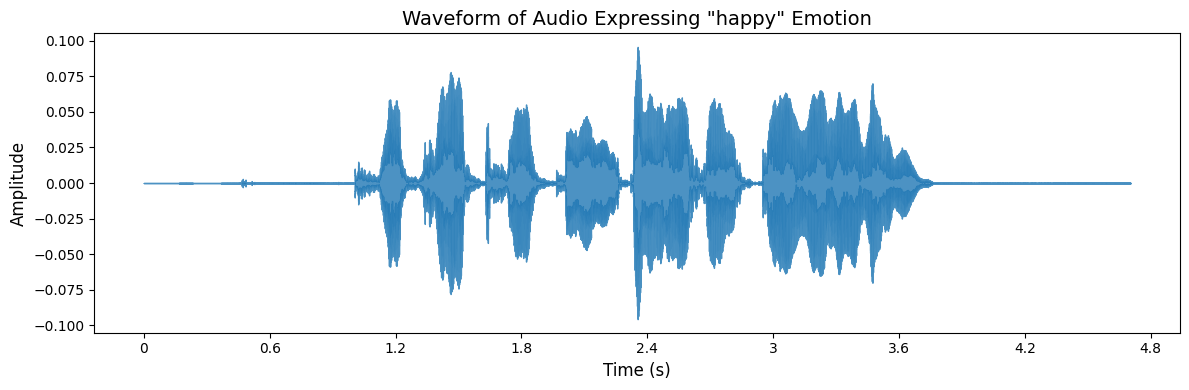

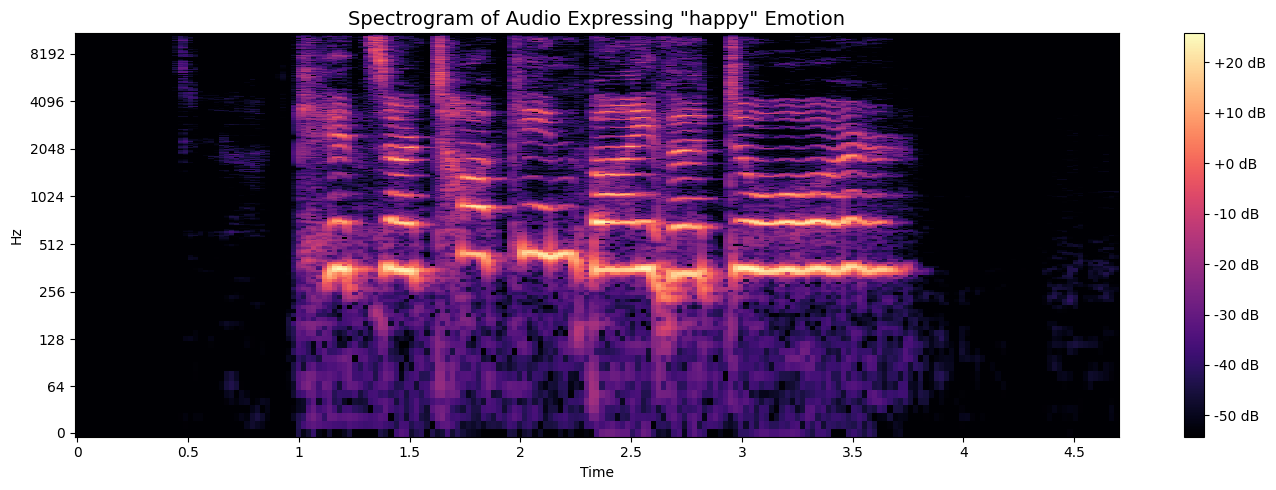

Generating Spectrogram and Waveform plots for calm 

Processing Emotion: Calm


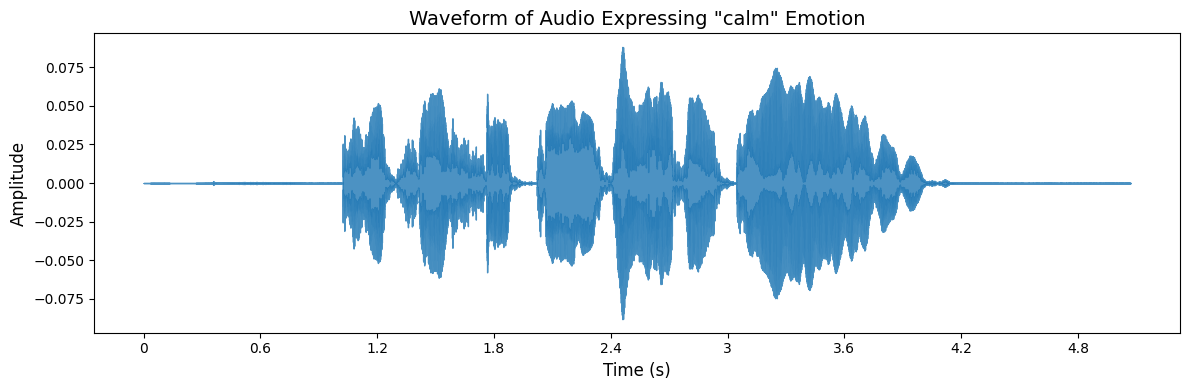

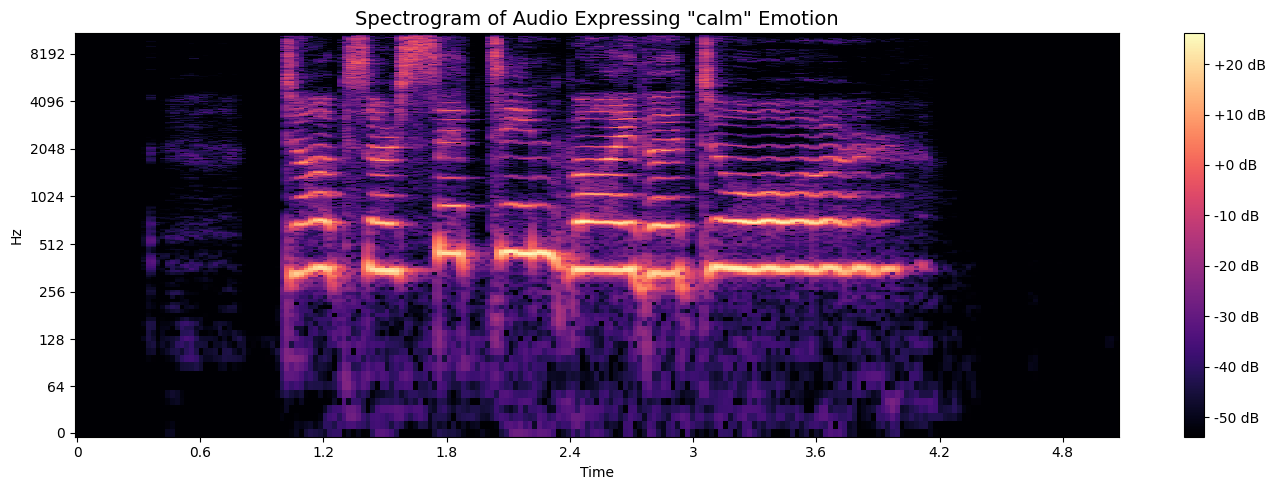

Generating Spectrogram and Waveform plots for fear 

Processing Emotion: Fear


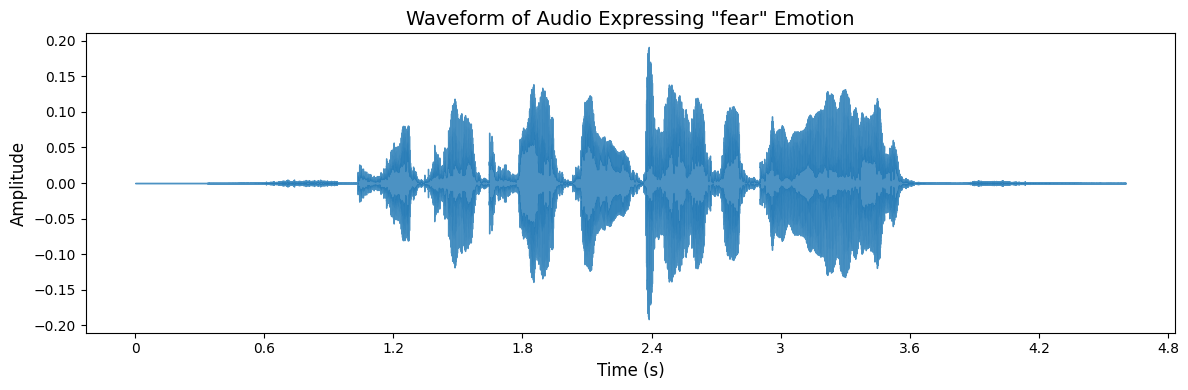

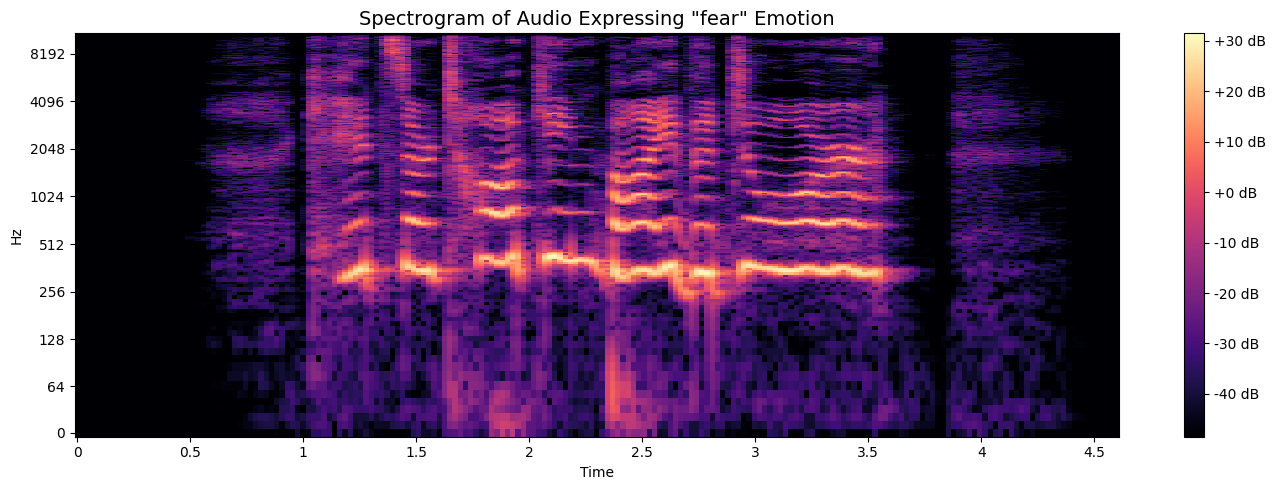

Generating Spectrogram and Waveform plots for angry 

Processing Emotion: Angry


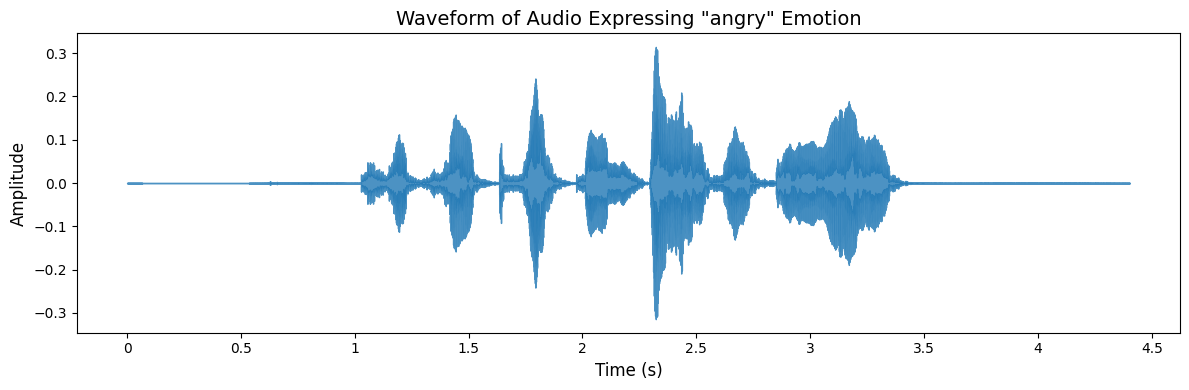

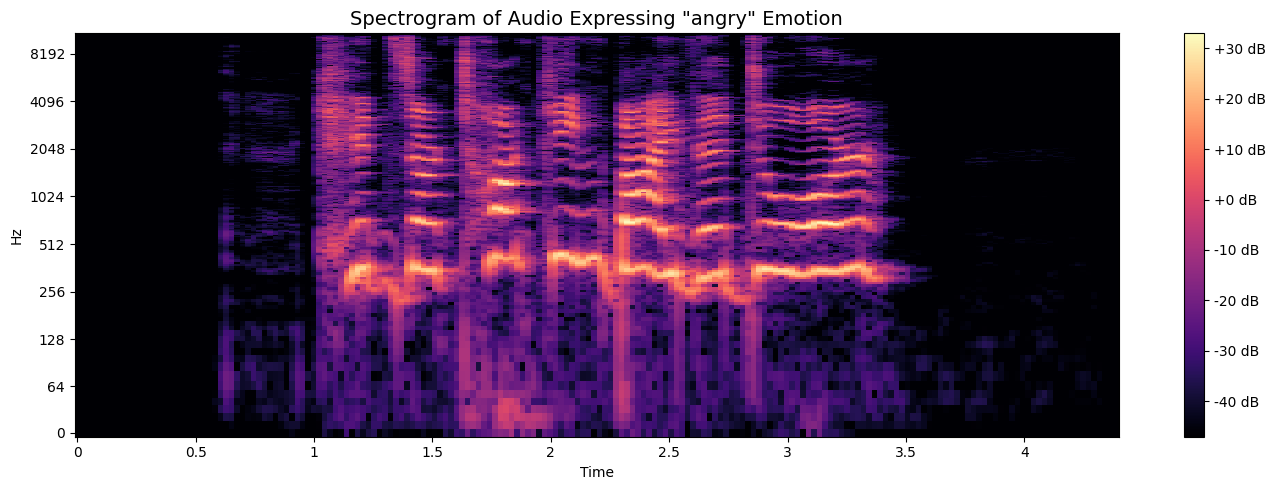

Generating Spectrogram and Waveform plots for sad 

Processing Emotion: Sad


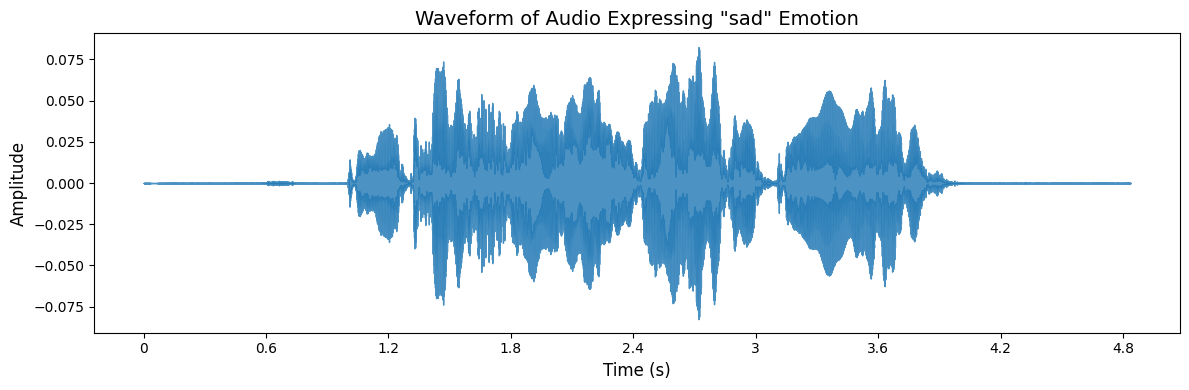

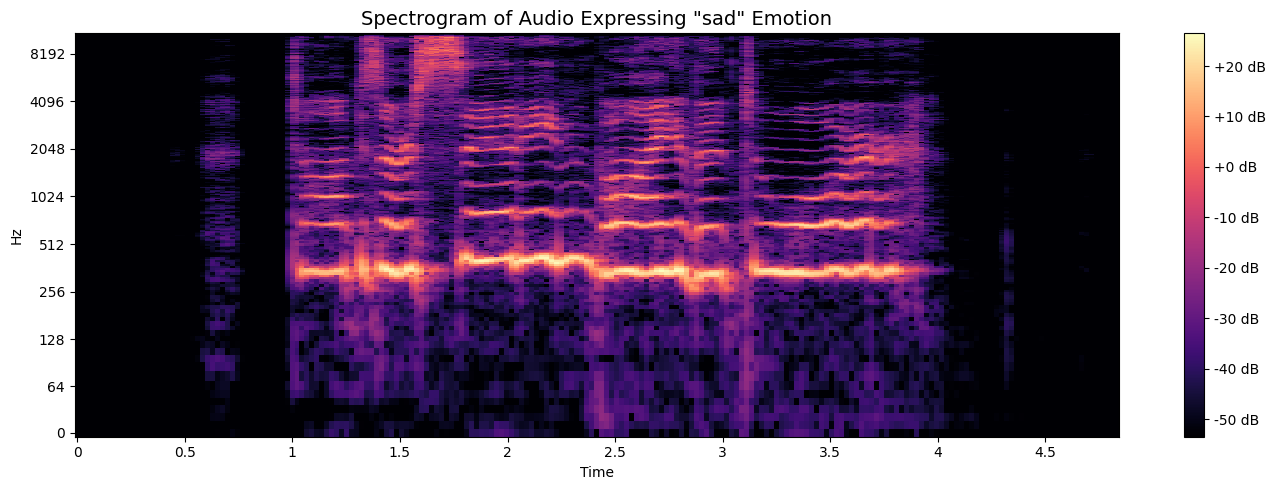

Generating Spectrogram and Waveform plots for disgust 

Processing Emotion: Disgust


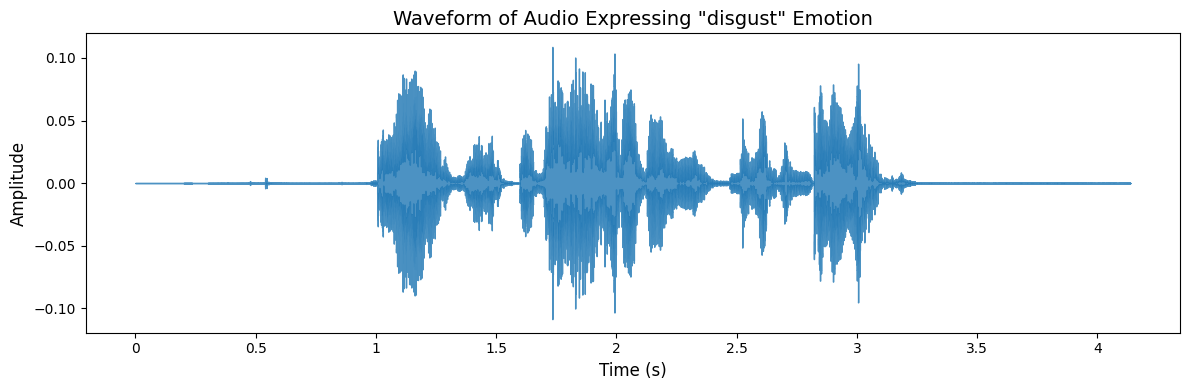

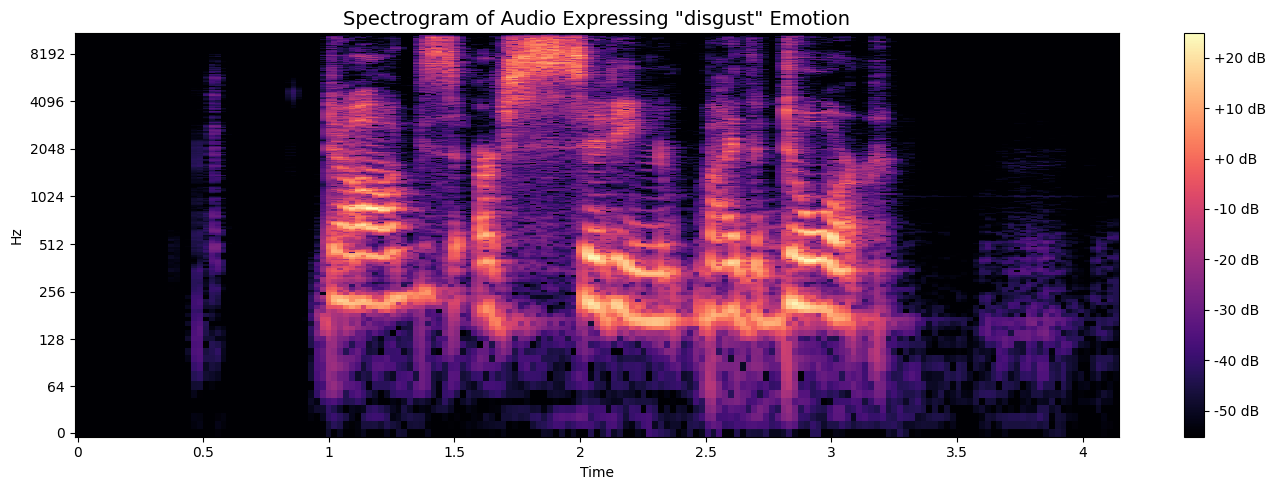

Generating Spectrogram and Waveform plots for surprise 

Processing Emotion: Surprise


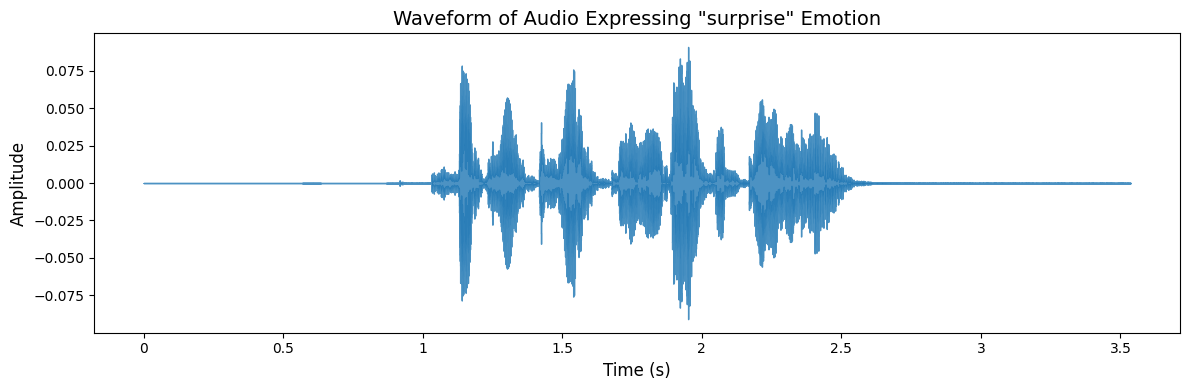

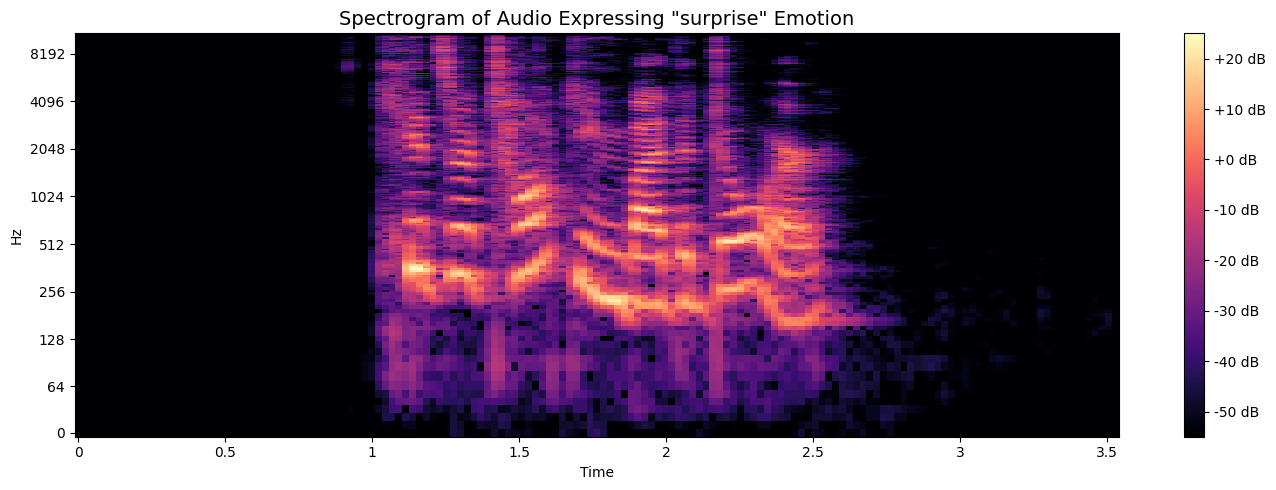

Generating Spectrogram and Waveform plots for neutral 

Processing Emotion: Neutral


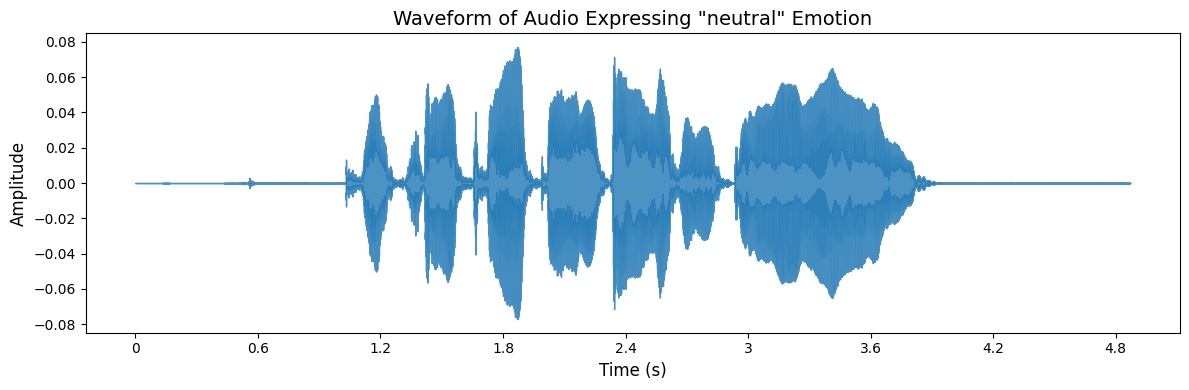

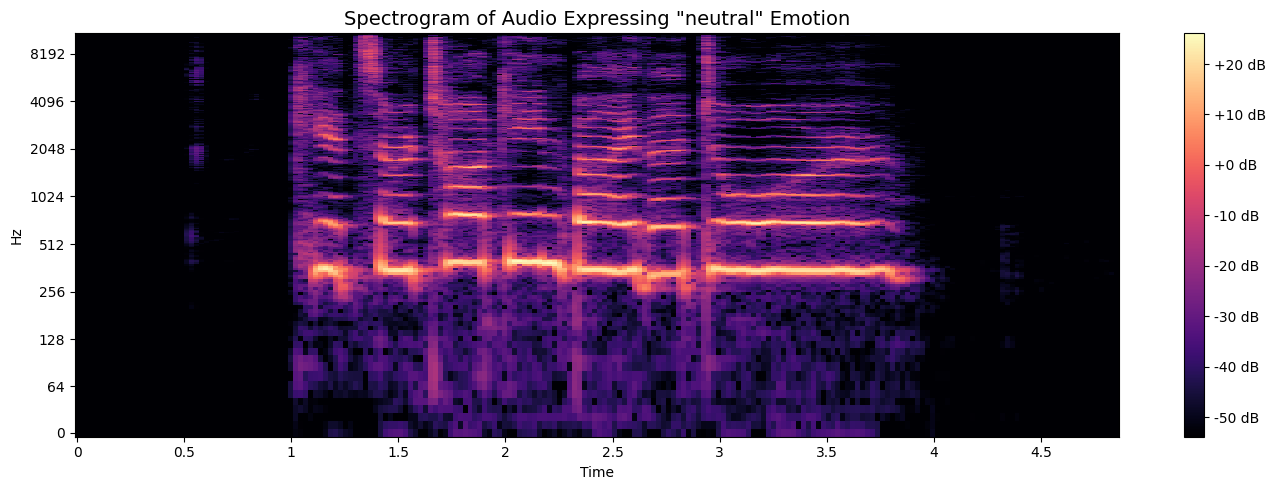

In [154]:
#Visualising waveforms and spectrogram for all emotions

emotion_labels = ['happy', 'calm', 'fear', 'angry', 'sad', 'disgust', 'surprise', 'neutral']
for emotion in emotion_labels:
    print(f"Generating Spectrogram and Waveform plots for {emotion} \n")
    print(f"Processing Emotion: {emotion.capitalize()}")
    file_path = np.array(df.Path[df.Emotions == emotion])[1] 
    audio_data, sample_rate = librosa.load(file_path)
    plot_waveform(audio_data, sample_rate, emotion)
    plot_spectrogram(audio_data, sample_rate, emotion)




FEATURE EXTRACTION

In [155]:
#defining extract_features to extract various features
def extract_features(audio, sample_rate):
    """
    Features extracted:
    - MFCCs
    - Zero Crossing Rate
    - Mel-spectrogram
    - Chroma STFT
    - Root Mean Square Energy
    """
    features = []

    # STFT magnitude
    stft_mag = np.abs(librosa.stft(audio))

    # MFCCs
    mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate)
    features.extend(np.mean(mfcc.T, axis=0))

    # Zero Crossing Rate
    zcr = librosa.feature.zero_crossing_rate(y=audio)
    features.extend(np.mean(zcr.T, axis=0))

    # Mel Spectrogram
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
    features.extend(np.mean(mel_spec.T, axis=0))

    # Chroma STFT
    chroma_stft = librosa.feature.chroma_stft(S=stft_mag, sr=sample_rate)
    features.extend(np.mean(chroma_stft.T, axis=0))

    # Root Mean Square Energy
    rms_energy = librosa.feature.rms(y=audio)
    features.extend(np.mean(rms_energy.T, axis=0))

    return np.array(features)


def get_features_from_file(file_path):
    """
    Load an audio file and return features extracted from the original and augmented audio.
    """
    audio, sample_rate = librosa.load(file_path, duration=2.5, offset=0.6)
    base_features = extract_features(audio, sample_rate)
    features_matrix = [base_features]
    return np.vstack(features_matrix)


In [156]:
#Extracting features and tracking by tqdm       
original_features = []
original_labels = []
original_paths = df['Path'].values
original_emotions = df['Emotions'].values

for audio_path, emotion_label in tqdm(zip(original_paths, original_emotions), total=len(df), desc="Extracting base features"):
    feature_variants = get_features_from_file(audio_path)
    for feature_vector in feature_variants:
        original_features.append(feature_vector)
        original_labels.append(emotion_label)



Extracting base features: 100%|██████████| 2452/2452 [00:25<00:00, 97.56it/s] 


In [157]:
#creating dataframe for features
features = pd.DataFrame(original_features)
features['labels'] = original_labels
features.to_csv('features.csv', index=False)
features = pd.read_csv('features.csv')
features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,-425.993744,34.595085,-13.257239,14.242723,-7.007360,-27.063345,-16.800310,-18.878283,-16.178129,3.052123,...,0.427376,0.625006,0.542138,0.387537,0.423156,0.564723,0.499385,0.414008,0.023445,happy
1,-495.328186,44.772629,-15.880418,15.731727,-4.508982,-22.982922,-14.772980,-21.664711,-13.512825,4.690958,...,0.478795,0.619626,0.438503,0.346835,0.441505,0.589606,0.454834,0.392530,0.012908,happy
2,-495.247650,44.244240,-14.295378,8.922749,-6.143208,-26.771385,-19.090855,-16.658363,-10.391972,-0.826961,...,0.517394,0.638355,0.434608,0.356800,0.403487,0.557761,0.435191,0.404209,0.014390,calm
3,-494.537842,29.287210,-7.035437,10.259418,-5.799279,-23.190626,-23.068111,-18.843077,-12.361567,-0.237903,...,0.506179,0.618466,0.399043,0.326444,0.417468,0.581796,0.448998,0.414384,0.014010,calm
4,-532.101868,39.040058,-1.655649,11.193638,-9.851658,-22.513216,-20.033501,-14.082188,-14.539296,-3.583384,...,0.476779,0.668807,0.496956,0.473597,0.408386,0.337263,0.284724,0.374417,0.009718,neutral


DATA PREPROCESSING

In [158]:
# Splitting the data into training and testing sets

X_train, X_test, y_train, y_test, path_train, _ = train_test_split(
    original_features, original_labels, original_paths, 
    test_size=0.2, stratify=original_labels, random_state=42, shuffle=True
)

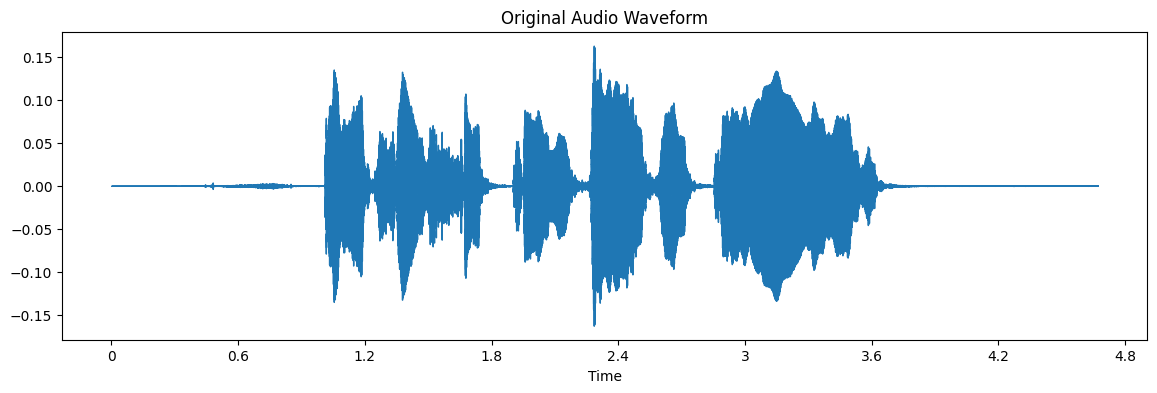

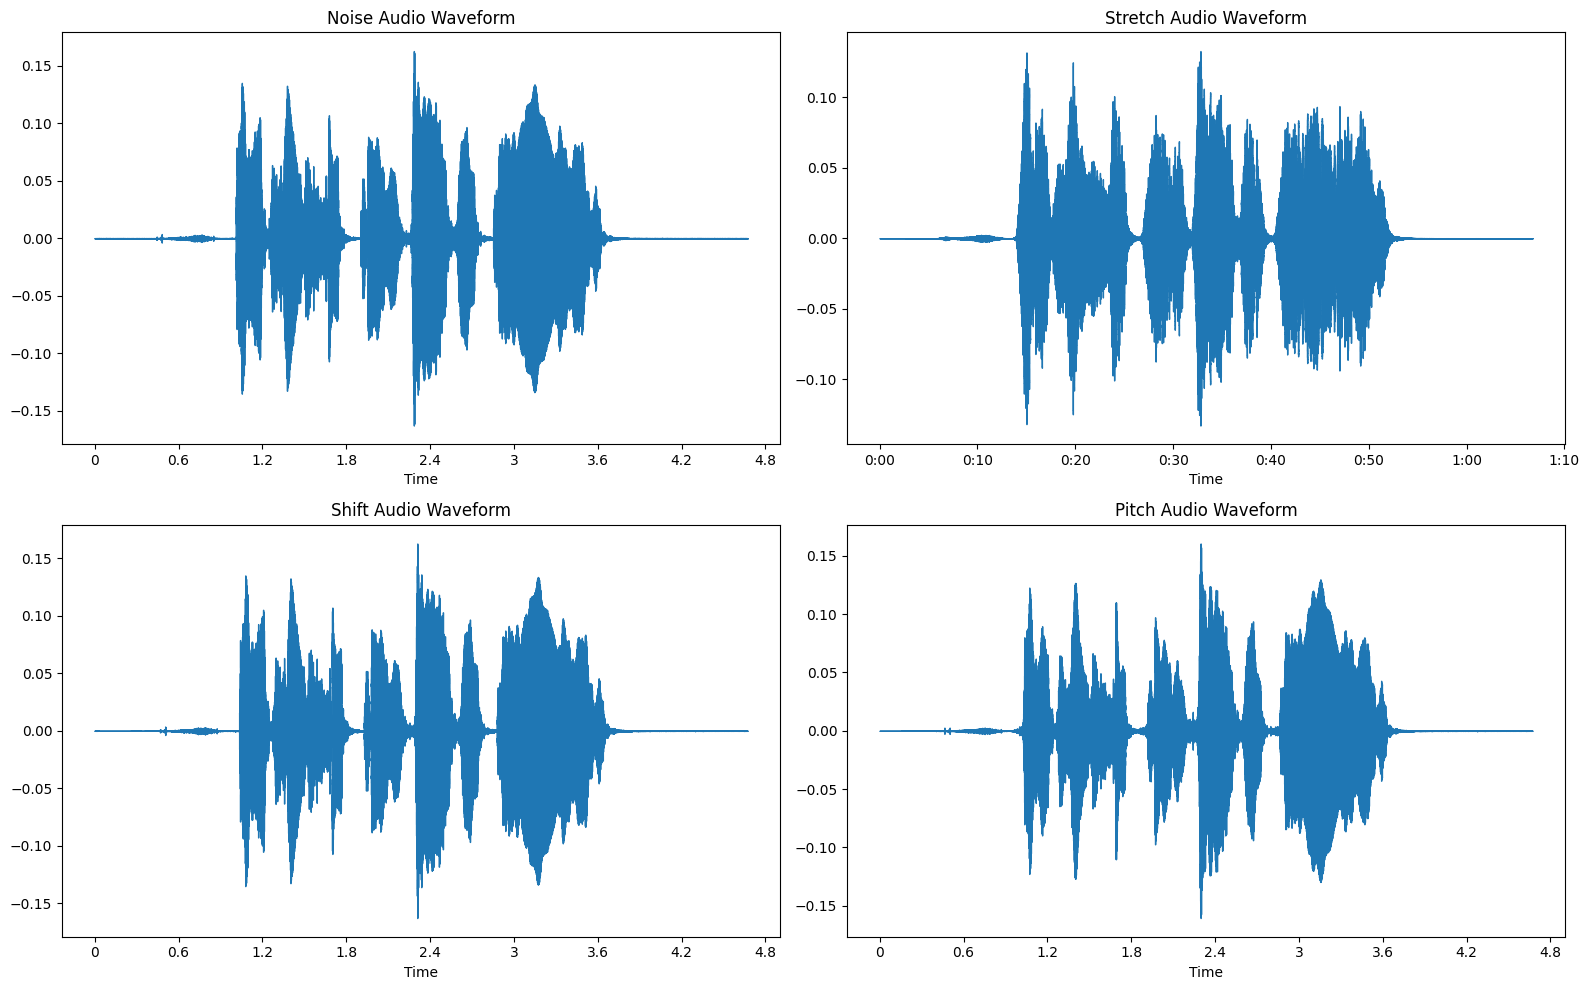

In [159]:
#Defining audio data augmentation functions
def add_noise(audio, noise_level=0.010):
    """
    Add random Gaussian noise to the audio signal.
    """
    amplitude = noise_level * np.random.uniform() * np.max(audio)
    noise = amplitude * np.random.normal(size=audio.shape[0])
    return audio + noise

def time_stretch(audio, stretch_range=0.07):
    """
    Stretch or compress audio in time without changing pitch.
    """
    # srate=np.random.uniform(*stretch_range)
    return librosa.effects.time_stretch(y=audio, rate=stretch_range)

def time_shift(audio, max_shift_ms=5):
    """
    Shift audio in time to simulate delay or advance.
    """
    shift_amount = int(np.random.uniform(low=-max_shift_ms, high=max_shift_ms) * 1000)
    return np.roll(audio, shift_amount)

def pitch_shift(audio, sample_rate, pitch_range=(-1,1)):
    """
    Change the pitch of the audio signal.
    """
    steps=np.random.uniform(*pitch_range)
    return librosa.effects.pitch_shift(y=audio, sr=sample_rate, n_steps=steps)


# Compariing different Data augmentation methods-
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
plt.title("Original Audio Waveform")
plt.show()

transformed = {
    "Noise": add_noise(data),
    "Stretch": time_stretch(data),
    "Shift": time_shift(data),
    "Pitch": pitch_shift(data, sample_rate)
}
plt.figure(figsize=(16, 10))

for i, (title, x) in enumerate(transformed.items(), 1):
    plt.subplot(2, 2, i)
    librosa.display.waveshow(y=x, sr=sample_rate)
    plt.title(f"{title} Audio Waveform")

plt.tight_layout()
plt.show()


In [ ]:
#Augmentation of training set only
augmented_X = []
augmented_y = []

for path, label in tqdm(zip(path_train, y_train), total=len(path_train), desc="Augmenting training data"):
    audio, sr = librosa.load(path, duration=2.5, offset=0.6)

    for aug_audio in [
        add_noise(audio),
        pitch_shift(audio, sr),
        time_stretch(audio)
    ]:  #the model does not work upon the waveform directly, rather it is trained on extracted features ---> 
        #augmentation changes the waveform and hence the features are also changed--->
        #extracting final features from train data for the model
        try:
            features = extract_features(aug_audio, sr)
            augmented_X.append(features)
            augmented_y.append(label)
        except:
            continue


Augmenting training data: 100%|██████████| 1961/1961 [07:13<00:00,  4.52it/s]


In [182]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)


In [183]:
#Class imbalance handling using oversampling method-SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train_encoded)


In [184]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train_resampled)
X_test_scaled=scaler.transform(X_test)

In [185]:
#Encoding using OneHot Encoder as it is a multi-class classification model
# y_test = np.array(y_test)
# augmented_y=np.array(augmented_y)

# encoder = OneHotEncoder()
# y_train_final = encoder.fit_transform(augmented_y.reshape(-1, 1)).toarray()
# y_test_final = encoder.transform(y_test.reshape(-1, 1)).toarray()

# X_train_final=np.array(augmented_X)
# X_test_final=np.array(X_test)

from tensorflow.keras.utils import to_categorical
y_train_final = to_categorical(y_train_resampled)
y_test_final = to_categorical(le.transform(y_test))  # match label encoder

# shapes
print("Training Features:", X_train_scaled.shape)
print("Training Labels:", y_train_final.shape)
print("Testing Features:", X_test_scaled.shape)
print("Testing Labels:", y_test_final.shape)

Training Features: (2408, 162)
Training Labels: (2408, 8)
Testing Features: (491, 162)
Testing Labels: (491, 8)


MODEL

In [200]:
#check cuda
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:

class CNNLSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNNLSTM, self).__init__()

        self.conv = nn.Sequential(
            # Conv Block 1
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.3),

            # Conv Block 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.3),

            # Conv Block 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d((1, 2)),
            nn.Dropout(0.4),

            # Conv Block 4
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d((1, 1)),  
            nn.Dropout(0.4)
        )

        self.lstm_input_size = 256 * 9  
        self.lstm_hidden = 128          
        self.lstm = nn.LSTM(
            input_size=self.lstm_input_size,
            hidden_size=self.lstm_hidden,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )

        self.classifier = nn.Sequential(
            nn.Linear(self.lstm_hidden * 2, 128),      
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)                
        )

    def forward(self, x):
        x = self.conv(x)                              # [B, 256, 9, W]
        x = x.permute(0, 3, 1, 2)                     # [B, W, 256, 9]
        x = x.contiguous().view(x.size(0), x.size(1), -1)  # [B, W, 256*9]
        lstm_out, _ = self.lstm(x)                    # [B, W, 256]
        out = lstm_out[:, -1, :]                      # Take last time step
        out = self.classifier(out)
        return F.log_softmax(out, dim=1)



In [208]:
# Data Preparation

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Reshaping features for CNN input [B, C=1, H=9, W=18]
X_train_tensor = torch.tensor(X_train_scaled.reshape(-1, 1, 9, 18), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.reshape(-1, 1, 9, 18), dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train_final, axis=1), dtype=torch.long)
y_test_tensor = torch.tensor(np.argmax(y_test_final, axis=1), dtype=torch.long)

#Confirming number of classes (not strictly needed if labels already integers)
le = LabelEncoder()
le.fit(y_train_tensor.numpy())
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")

# Creating TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cpu
Number of classes: 8


In [209]:
#Setup for Training
# Initialize the model
model = CNNLSTM(num_classes=num_classes).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,weight_decay=1e-4)
criterion = nn.NLLLoss()

# Learning rate scheduler (reducing LR on plateau)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# Training history trackers
train_loss_history, test_loss_history = [], []
train_accuracy_history, test_accuracy_history = [], []

best_test_accuracy = 0.0
num_epochs = 150

print("Training setup complete.")


Training setup complete.


In [210]:
import time

# Initialize variables
best_test_accuracy = 0.0
patience = 20
counter = 0

total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    train_correct, train_total, train_loss_sum = 0, 0, 0.0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

    for batch_x, batch_y in train_loop:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        _, preds = torch.max(predictions, 1)
        train_total += batch_y.size(0)
        train_correct += (preds == batch_y).sum().item()

        train_loop.set_postfix(loss=loss.item(), acc=train_correct/train_total)

    train_loss = train_loss_sum / len(train_loader)
    train_accuracy = train_correct / train_total

    # ---- Evaluation Phase ----
    model.eval()
    test_correct, test_total, test_loss_sum = 0, 0, 0.0
    test_loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Testing]")

    with torch.no_grad():
        for batch_x, batch_y in test_loop:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)

            test_loss_sum += loss.item()
            _, preds = torch.max(predictions, 1)
            test_total += batch_y.size(0)
            test_correct += (preds == batch_y).sum().item()

            test_loop.set_postfix(loss=loss.item(), acc=test_correct/test_total)

    test_loss = test_loss_sum / len(test_loader)
    test_accuracy = test_correct / test_total

    scheduler.step(train_loss)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    # # ---- Early Stopping Logic ----
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f" Early stopping triggered at epoch {epoch+1}")
            break

    # Logging
    epoch_duration = time.time() - epoch_start_time
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f} | "
              f"Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f} | "
              f"Time: {epoch_duration:.2f} sec")

# Total training time
total_duration = time.time() - total_start_time
print(f"\nTraining complete in {total_duration/60:.2f} minutes ({total_duration:.2f} seconds)")




Epoch 1/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 85.58it/s, acc=0.308, loss=1.85]


Epoch 001 | Train Loss: 2.0068, Acc: 0.2238 | Test Loss: 1.8926, Acc: 0.3075 | Time: 3.48 sec


Epoch 10/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 87.27it/s, acc=0.44, loss=1.42]


Epoch 010 | Train Loss: 1.4946, Acc: 0.4348 | Test Loss: 1.4919, Acc: 0.4399 | Time: 3.05 sec


Epoch 20/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 95.97it/s, acc=0.503, loss=1.12]


Epoch 020 | Train Loss: 1.2216, Acc: 0.5586 | Test Loss: 1.4452, Acc: 0.5031 | Time: 2.88 sec


Epoch 30/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 97.62it/s, acc=0.497, loss=1.06]


Epoch 030 | Train Loss: 1.0428, Acc: 0.6250 | Test Loss: 1.3945, Acc: 0.4969 | Time: 3.02 sec


Epoch 40/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 91.78it/s, acc=0.605, loss=0.758]


Epoch 040 | Train Loss: 0.9246, Acc: 0.6686 | Test Loss: 1.2062, Acc: 0.6049 | Time: 2.82 sec


Epoch 50/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 95.68it/s, acc=0.631, loss=0.925]


Epoch 050 | Train Loss: 0.7844, Acc: 0.7226 | Test Loss: 1.0642, Acc: 0.6314 | Time: 2.86 sec


Epoch 60/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 85.68it/s, acc=0.615, loss=0.721]


Epoch 060 | Train Loss: 0.7066, Acc: 0.7620 | Test Loss: 1.1469, Acc: 0.6151 | Time: 2.93 sec


Epoch 70/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 80.71it/s, acc=0.648, loss=0.577]


Epoch 070 | Train Loss: 0.6435, Acc: 0.7695 | Test Loss: 1.1582, Acc: 0.6477 | Time: 2.98 sec


Epoch 80/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 86.45it/s, acc=0.68, loss=0.429]


Epoch 080 | Train Loss: 0.6006, Acc: 0.7961 | Test Loss: 0.9183, Acc: 0.6802 | Time: 2.88 sec


Epoch 90/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 88.94it/s, acc=0.668, loss=0.585]


Epoch 090 | Train Loss: 0.5377, Acc: 0.8169 | Test Loss: 1.0523, Acc: 0.6680 | Time: 2.93 sec


Epoch 100/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 75.56it/s, acc=0.688, loss=0.628]


Epoch 100 | Train Loss: 0.4815, Acc: 0.8326 | Test Loss: 0.9993, Acc: 0.6884 | Time: 3.41 sec


Epoch 110/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 82.70it/s, acc=0.69, loss=0.488]


Epoch 110 | Train Loss: 0.4751, Acc: 0.8380 | Test Loss: 0.9384, Acc: 0.6904 | Time: 2.93 sec


Epoch 120/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 74.38it/s, acc=0.69, loss=0.62] 


Epoch 120 | Train Loss: 0.4349, Acc: 0.8468 | Test Loss: 0.9381, Acc: 0.6904 | Time: 3.06 sec


Epoch 130/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 78.49it/s, acc=0.658, loss=0.484]


Epoch 130 | Train Loss: 0.4083, Acc: 0.8642 | Test Loss: 1.1988, Acc: 0.6578 | Time: 3.05 sec


Epoch 133/150 [Testing]: 100%|██████████| 16/16 [00:00<00:00, 85.65it/s, acc=0.707, loss=0.349]

 Early stopping triggered at epoch 133

Training complete in 6.70 minutes (401.96 seconds)


In [211]:
print("\n Final Training Results:")
print(f"Epoch {num_epochs:03d} | Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f} | "
      f"Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f} | "
      f"Time: {epoch_duration:.2f} sec")


 Final Training Results:
Epoch 150 | Train Loss: 0.3870, Acc: 0.8650 | Test Loss: 0.8974, Acc: 0.7067 | Time: 2.96 sec


In [212]:
# === Final Evaluation ====================================================================================================
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        true_labels.extend(targets.numpy())
        predicted_labels.extend(predictions)

# --- Classification Metrics ---
print("\n Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=[str(cls) for cls in le.classes_]))

# --- Confusion Matrix ---
print(" Confusion Matrix:")
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\n Final Test Accuracy: {accuracy:.4f}")



 Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.83      0.83        75
           1       0.88      0.77      0.82        75
           2       0.54      0.82      0.65        39
           3       0.72      0.55      0.62        75
           4       0.79      0.60      0.68        75
           5       0.60      0.95      0.73        38
           6       0.61      0.56      0.58        75
           7       0.71      0.87      0.78        39

    accuracy                           0.71       491
   macro avg       0.71      0.74      0.71       491
weighted avg       0.73      0.71      0.71       491

 Confusion Matrix:
[[62  0  8  1  2  0  1  1]
 [ 0 58  2  0  0 12  3  0]
 [ 1  0 32  2  0  0  0  4]
 [ 6  2  2 41  4  1 17  2]
 [ 3  1  9  4 45  4  5  4]
 [ 0  1  0  0  0 36  0  1]
 [ 2  4  6  9  4  6 42  2]
 [ 1  0  0  0  2  1  1 34]]

 Final Test Accuracy: 0.7128


Clearly  the class 06 has very low accuracy as well as f1 score, reducing the  overall accuracy of the model,
Hence,We will drop the class 06 and again train the model with num_classes=7

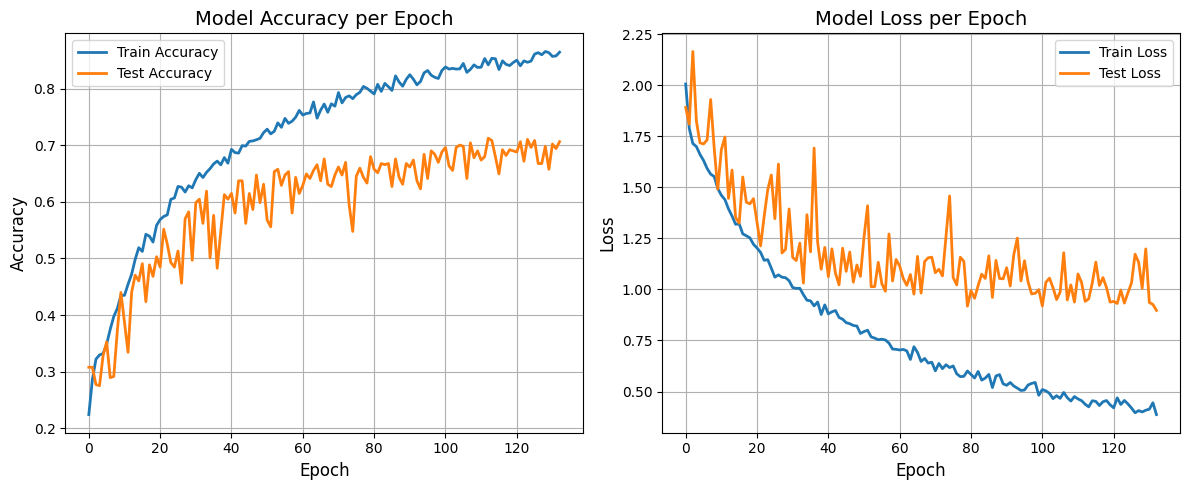

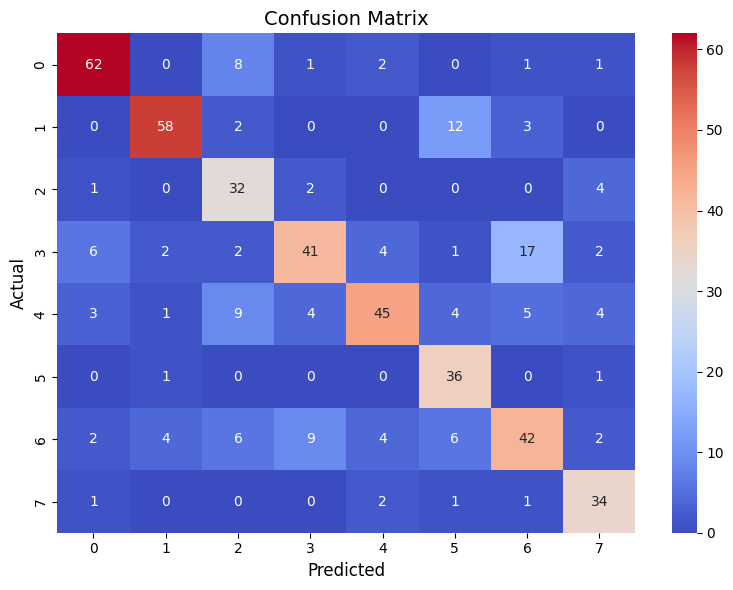

In [213]:
#Results Visualisation

# --- Accuracy and Loss over Epochs ---------------------------------------------------------------------------------------------
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_history, label='Train Accuracy', linewidth=2)
plt.plot(test_accuracy_history, label='Test Accuracy', linewidth=2)
plt.title("Model Accuracy per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss', linewidth=2)
plt.plot(test_loss_history, label='Test Loss', linewidth=2)
plt.title("Model Loss per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=[str(cls) for cls in le.classes_],
            yticklabels=[str(cls) for cls in le.classes_])

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()



Dropping the class 06

In [222]:
# dropping class 06
df = df[df['Emotions'] != 6].reset_index(drop=True)

In [223]:

# Re-encoding labels
le = LabelEncoder()
df['Emotions'] = le.fit_transform(df['Emotions'])

In [224]:
print(df['Emotions'].value_counts())  # Should not contain 6


Emotions
4    376
1    376
3    376
0    376
2    192
6    192
5    188
Name: count, dtype: int64


In [225]:

le = LabelEncoder()
df['Emotions'] = le.fit_transform(df['Emotions'])

print("New Classes:", le.classes_)  # Confirm classes


New Classes: [0 1 2 3 4 5 6]


In [226]:
print(df['Emotions'].value_counts())  # Should not contain 6


Emotions
4    376
1    376
3    376
0    376
2    192
6    192
5    188
Name: count, dtype: int64


Data Preprocessing

In [227]:
#Extracting features and tracking by tqdm       
original_features = []
original_labels = []
original_paths = df['Path'].values
original_emotions = df['Emotions'].values

for audio_path, emotion_label in tqdm(zip(original_paths, original_emotions), total=len(df), desc="Extracting base features"):
    feature_variants = get_features_from_file(audio_path)
    for feature_vector in feature_variants:
        original_features.append(feature_vector)
        original_labels.append(emotion_label)



Extracting base features: 100%|██████████| 2076/2076 [00:22<00:00, 92.74it/s] 


In [231]:

# Splitting the data into training and testing sets

X_train, X_test, y_train, y_test, path_train, _ = train_test_split(
    original_features, original_labels, original_paths, 
    test_size=0.2, stratify=original_labels, random_state=42, shuffle=True
)

In [232]:

le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [233]:
#Augmentation of training set only
augmented_X = []
augmented_y = []

for path, label in tqdm(zip(path_train, y_train), total=len(path_train), desc="Augmenting training data"):
    audio, sr = librosa.load(path, duration=2.5, offset=0.6)

    for aug_audio in [
        add_noise(audio),
        pitch_shift(audio, sr),
        time_stretch(audio)
    ]:  #the model does not work upon the waveform directly, rather it is trained on extracted features ---> 
        #augmentation changes the waveform and hence the features are also changed--->
        #extracting final features from train data for the model
        try:
            features = extract_features(aug_audio, sr)
            augmented_X.append(features)
            augmented_y.append(label)
        except:
            continue


Augmenting training data: 100%|██████████| 1660/1660 [05:58<00:00,  4.64it/s]


In [234]:
#Class imbalance handling using oversampling method-SMOTE
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train_encoded)


In [235]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train_resampled)
X_test_scaled=scaler.transform(X_test)

In [236]:
#one hot encodiing
from tensorflow.keras.utils import to_categorical
y_train_final = to_categorical(y_train_resampled)
y_test_final = to_categorical(le.transform(y_test))  # match label encoder

# shapes
print("Training Features:", X_train_scaled.shape)
print("Training Labels:", y_train_final.shape)
print("Testing Features:", X_test_scaled.shape)
print("Testing Labels:", y_test_final.shape)

Training Features: (2107, 162)
Training Labels: (2107, 7)
Testing Features: (416, 162)
Testing Labels: (416, 7)


In [237]:
#check cuda
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [238]:
# Data Preparation

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Reshaping features for CNN input [B, C=1, H=9, W=18]
X_train_tensor = torch.tensor(X_train_scaled.reshape(-1, 1, 9, 18), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled.reshape(-1, 1, 9, 18), dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train_final, axis=1), dtype=torch.long)
y_test_tensor = torch.tensor(np.argmax(y_test_final, axis=1), dtype=torch.long)

#Confirming number of classes (not strictly needed if labels already integers)
le = LabelEncoder()
le.fit(y_train_tensor.numpy())
num_classes = len(le.classes_)
print(f"Number of classes: {num_classes}")

# Creating TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Using device: cpu
Number of classes: 7


In [239]:
#Setup for Training
# Initialize the model
model = CNNLSTM(num_classes=7).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001,weight_decay=1e-4)
criterion = nn.NLLLoss()

# Learning rate scheduler (reducing LR on plateau)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

# Training history trackers
train_loss_history, test_loss_history = [], []
train_accuracy_history, test_accuracy_history = [], []

best_test_accuracy = 0.0
num_epochs = 100

print("Training setup complete.")


Training setup complete.


In [249]:
import time

# Initialize variables
best_test_accuracy = 0.0
patience = 20
counter = 0

total_start_time = time.time()

for epoch in range(num_epochs):
    epoch_start_time = time.time()
    model.train()
    train_correct, train_total, train_loss_sum = 0, 0, 0.0
    train_loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

    for batch_x, batch_y in train_loop:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        predictions = model(batch_x)
        loss = criterion(predictions, batch_y)
        loss.backward()
        optimizer.step()

        train_loss_sum += loss.item()
        _, preds = torch.max(predictions, 1)
        train_total += batch_y.size(0)
        train_correct += (preds == batch_y).sum().item()

        train_loop.set_postfix(loss=loss.item(), acc=train_correct/train_total)

    train_loss = train_loss_sum / len(train_loader)
    train_accuracy = train_correct / train_total

    # ---- Evaluation Phase ----
    model.eval()
    test_correct, test_total, test_loss_sum = 0, 0, 0.0
    test_loop = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Testing]")

    with torch.no_grad():
        for batch_x, batch_y in test_loop:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            predictions = model(batch_x)
            loss = criterion(predictions, batch_y)

            test_loss_sum += loss.item()
            _, preds = torch.max(predictions, 1)
            test_total += batch_y.size(0)
            test_correct += (preds == batch_y).sum().item()

            test_loop.set_postfix(loss=loss.item(), acc=test_correct/test_total)

    test_loss = test_loss_sum / len(test_loader)
    test_accuracy = test_correct / test_total

    scheduler.step(train_loss)

    train_loss_history.append(train_loss)
    test_loss_history.append(test_loss)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    # # ---- Early Stopping Logic ----
    if test_accuracy > best_test_accuracy:
        best_test_accuracy = test_accuracy
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print(f" Early stopping triggered at epoch {epoch+1}")
            break

    # Logging
    epoch_duration = time.time() - epoch_start_time
    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:03d} | Train Loss: {train_loss:.4f}, Acc: {train_accuracy:.4f} | "
              f"Test Loss: {test_loss:.4f}, Acc: {test_accuracy:.4f} | "
              f"Time: {epoch_duration:.2f} sec")

# Total training time
total_duration = time.time() - total_start_time
print(f"\nTraining complete in {total_duration/60:.2f} minutes ({total_duration:.2f} seconds)")




Epoch 1/100 [Testing]: 100%|██████████| 13/13 [00:00<00:00, 78.81it/s, acc=0.75, loss=0.762]


Epoch 001 | Train Loss: 0.3741, Acc: 0.8790 | Test Loss: 0.8093, Acc: 0.7500 | Time: 6.69 sec


Epoch 10/100 [Testing]: 100%|██████████| 13/13 [00:00<00:00, 90.35it/s, acc=0.76, loss=0.691]


Epoch 010 | Train Loss: 0.3242, Acc: 0.8870 | Test Loss: 0.8319, Acc: 0.7596 | Time: 2.44 sec


Epoch 20/100 [Testing]: 100%|██████████| 13/13 [00:00<00:00, 89.05it/s, acc=0.767, loss=1.09]


Epoch 020 | Train Loss: 0.3082, Acc: 0.8937 | Test Loss: 0.8049, Acc: 0.7668 | Time: 2.43 sec


Epoch 30/100 [Testing]: 100%|██████████| 13/13 [00:00<00:00, 86.49it/s, acc=0.776, loss=0.9] 


Epoch 030 | Train Loss: 0.2491, Acc: 0.9179 | Test Loss: 0.8093, Acc: 0.7764 | Time: 2.46 sec


Epoch 40/100 [Testing]: 100%|██████████| 13/13 [00:00<00:00, 69.22it/s, acc=0.757, loss=1.01]


Epoch 040 | Train Loss: 0.2425, Acc: 0.9231 | Test Loss: 0.7974, Acc: 0.7572 | Time: 2.61 sec


Epoch 50/100 [Testing]: 100%|██████████| 13/13 [00:00<00:00, 77.84it/s, acc=0.784, loss=0.922]


Epoch 050 | Train Loss: 0.2317, Acc: 0.9264 | Test Loss: 0.7548, Acc: 0.7837 | Time: 2.59 sec


Epoch 60/100 [Testing]: 100%|██████████| 13/13 [00:00<00:00, 75.78it/s, acc=0.793, loss=0.84]


Epoch 060 | Train Loss: 0.2424, Acc: 0.9236 | Test Loss: 0.7689, Acc: 0.7933 | Time: 2.74 sec


Epoch 69/100 [Testing]: 100%|██████████| 13/13 [00:00<00:00, 80.73it/s, acc=0.767, loss=0.878]

 Early stopping triggered at epoch 69

Training complete in 2.99 minutes (179.68 seconds)


In [250]:
# === Final Evaluation ====================================================================================================
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()
        true_labels.extend(targets.numpy())
        predicted_labels.extend(predictions)

# --- Classification Metrics ---
print("\n Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=[str(cls) for cls in le.classes_]))

# --- Confusion Matrix ---
print(" Confusion Matrix:")
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

accuracy = accuracy_score(true_labels, predicted_labels)
print(f"\n Final Test Accuracy: {accuracy:.4f}")



 Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.83      0.83        75
           1       0.88      0.91      0.89        75
           2       0.62      0.85      0.72        39
           3       0.85      0.77      0.81        75
           4       0.84      0.61      0.71        75
           5       0.72      0.89      0.80        38
           6       0.71      0.77      0.74        39

    accuracy                           0.80       416
   macro avg       0.78      0.80      0.79       416
weighted avg       0.81      0.80      0.79       416

 Confusion Matrix:
[[62  0  7  2  0  1  3]
 [ 0 68  0  0  2  5  0]
 [ 0  2 33  1  0  1  2]
 [ 2  4  3 58  5  2  1]
 [ 8  1  7  6 46  3  4]
 [ 0  2  0  0  0 34  2]
 [ 2  0  3  1  2  1 30]]

 Final Test Accuracy: 0.7957


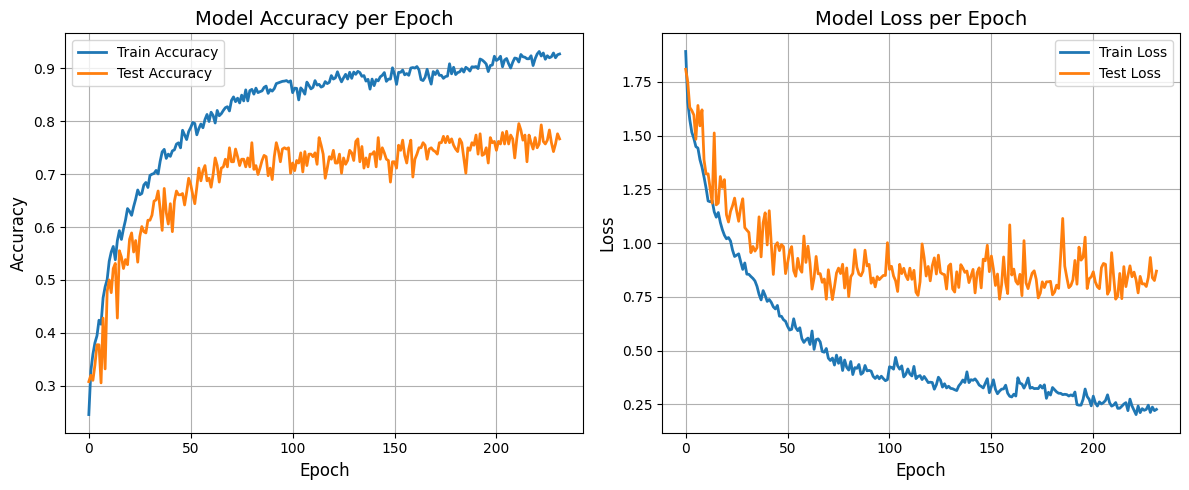

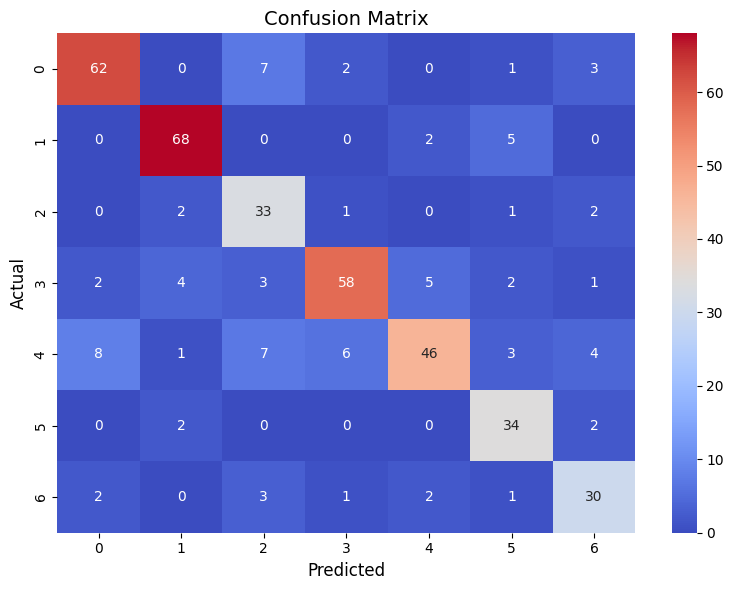

In [251]:
#Results Visualisation

# --- Accuracy and Loss over Epochs ---------------------------------------------------------------------------------------------
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(train_accuracy_history, label='Train Accuracy', linewidth=2)
plt.plot(test_accuracy_history, label='Test Accuracy', linewidth=2)
plt.title("Model Accuracy per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(train_loss_history, label='Train Loss', linewidth=2)
plt.plot(test_loss_history, label='Test Loss', linewidth=2)
plt.title("Model Loss per Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
            xticklabels=[str(cls) for cls in le.classes_],
            yticklabels=[str(cls) for cls in le.classes_])

plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.title("Confusion Matrix", fontsize=14)
plt.tight_layout()
plt.show()



In [252]:
#to csv file
print(df.shape)
df.to_csv("df.csv",index=False)

(2076, 2)
